In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Time_series_analysis_and_forecast_DATASET.csv to Time_series_analysis_and_forecast_DATASET.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Time_series_analysis_and_forecast_DATASET.csv']))

In [4]:
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


Text(0.5, 1.0, 'Prices of Electricity (Kw/hour)')

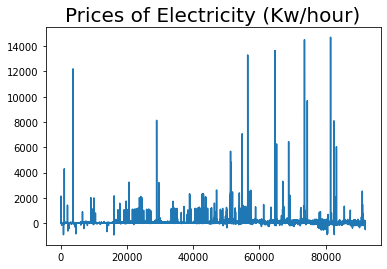

In [5]:
# Visualize
plt.plot(df["ElecPrice"])
plt.title('Prices of Electricity (Kw/hour)', size=20)

In [6]:
df.shape

(92016, 5)

In [7]:
df.isna().sum()

FullDate     0
Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

In [8]:
#convert the FullDate column to DateTime
df["FullDate"] = pd.to_datetime(df["FullDate"])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FullDate   92016 non-null  datetime64[ns]
 1   Tmax       92016 non-null  float64       
 2   SysLoad    92016 non-null  float64       
 3   GasPrice   92016 non-null  float64       
 4   ElecPrice  92016 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.5 MB


In [12]:
df1 = df.drop(columns=['Tmax', 'SysLoad','GasPrice'])
df1.set_index('FullDate', inplace = True)
df1.head()

,ElecPrice
FullDate,
2010-09-01 00:00:00,23.710
2010-09-01 01:00:00,22.635
2010-09-01 02:00:00,22.565
2010-09-01 03:00:00,18.910
2010-09-01 04:00:00,18.030


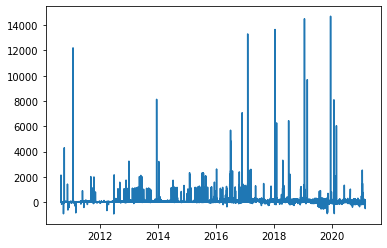

In [13]:
plt.plot(df1["ElecPrice"])

In [74]:
# test for sationarity

def stationarity_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    df_test = adfuller(timeseries, autolag="AIC")
    df_output = pd.Series(
        df_test[0:4],
        index = [
            "Test statistics",
            "p-value",
            "Number of lags used",
            "Number of observations used",
            "Critical Values"
        ]
    )
    print(df1_output)

In [38]:
df1_daily = df1.resample('D').sum()
df1_daily.head()

,ElecPrice
FullDate,
2010-09-01,2751.700
2010-09-02,570.810
2010-09-03,504.975
2010-09-04,502.275
2010-09-05,500.555


In [39]:
df1_daily = df1_daily.reset_index()
df1_daily = df1_daily.rename(columns={"FullDate": "ds", "ElecPrice": "y"})
df1_daily.head()

,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555


In [40]:
df1_daily.shape, df1_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3834 non-null   datetime64[ns]
 1   y       3834 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 60.0 KB


((3834, 2), None)

In [41]:
cutoff = 2757

df1_daily_train = df1_daily.iloc[:cutoff]
df1_daily_test = df1_daily.iloc[cutoff:]

In [42]:
df1_daily_train.shape, df1_daily_test.shape

((2757, 2), (1077, 2))

In [44]:
# Time series with Facebook Prophet
from fbprophet import Prophet

model = Prophet()
model.fit(df1_daily_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [49]:
# predict for the next 10 months
future = model.make_future_dataframe(periods=10, freq='D')
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-09-01,851.777631,-1656.592963,3264.136699,851.777631,851.777631,144.250503,144.250503,144.250503,159.308129,159.308129,159.308129,-15.057627,-15.057627,-15.057627,0.0,0.0,0.0,996.028134
1,2010-09-02,851.727173,-1306.147706,3491.714872,851.727173,851.727173,224.453910,224.453910,224.453910,257.036327,257.036327,257.036327,-32.582418,-32.582418,-32.582418,0.0,0.0,0.0,1076.181083
2,2010-09-03,851.676716,-1549.634456,3296.802330,851.676716,851.676716,-0.584510,-0.584510,-0.584510,50.257478,50.257478,50.257478,-50.841988,-50.841988,-50.841988,0.0,0.0,0.0,851.092206
3,2010-09-04,851.626258,-1712.127363,2866.858369,851.626258,851.626258,-340.872526,-340.872526,-340.872526,-271.372061,-271.372061,-271.372061,-69.500465,-69.500465,-69.500465,0.0,0.0,0.0,510.753732
4,2010-09-05,851.575800,-2044.580296,2797.071088,851.575800,851.575800,-430.884955,-430.884955,-430.884955,-342.634443,-342.634443,-342.634443,-88.250512,-88.250512,-88.250512,0.0,0.0,0.0,420.690845


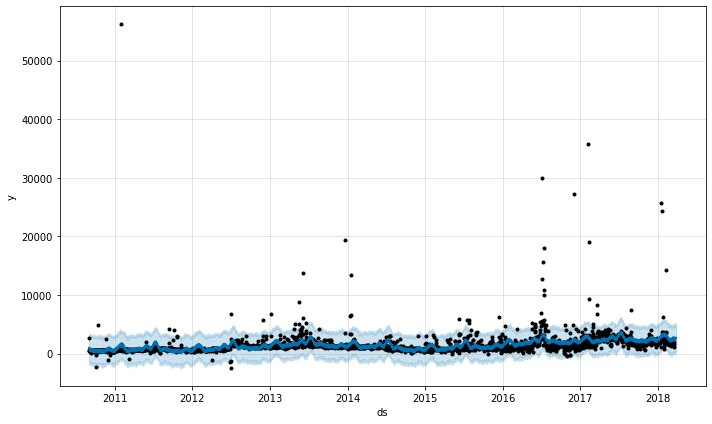

In [50]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]
#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries

model.plot(forecast)
plt.show()

In [51]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2010-09-01,996.028134,-1656.592963,3264.136699
1,2010-09-02,1076.181083,-1306.147706,3491.714872
2,2010-09-03,851.092206,-1549.634456,3296.802330
3,2010-09-04,510.753732,-1712.127363,2866.858369
4,2010-09-05,420.690845,-2044.580296,2797.071088


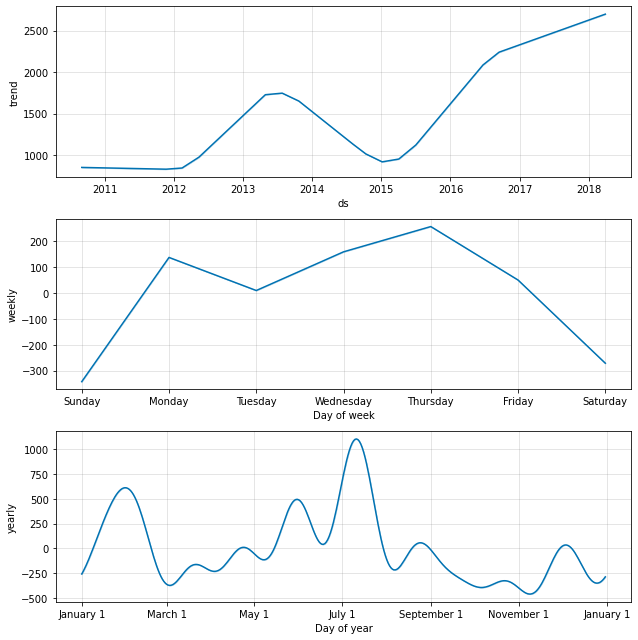

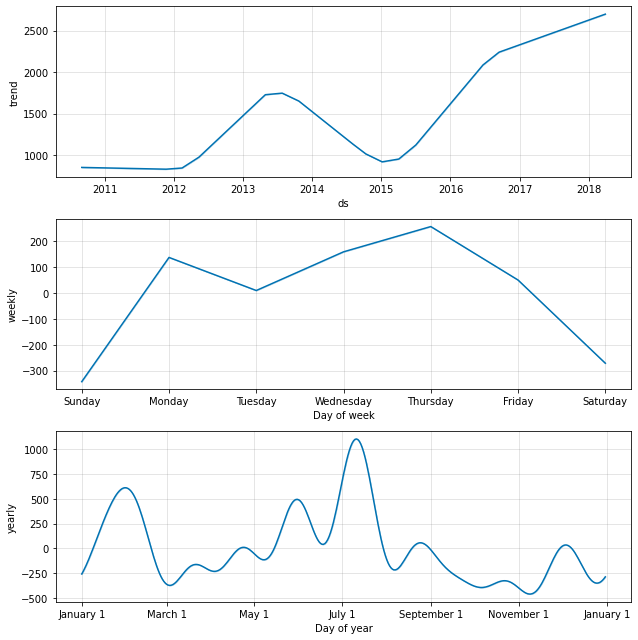

In [52]:
model.plot_components(forecast)

In [56]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [57]:
# MAPE Value
round(mean_absolute_percentage_error(df1_daily_test['y'], forecast['yhat'][-1077:]),2)

416.17

In [58]:
# RMSE Calculation
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(df1_daily_test['y'], forecast['yhat'][-1077:]))
print(round(rmse,2))

3059.84


In [60]:
df.set_index(df.FullDate, inplace = True)
df_daily = df.resample('D').sum()
df_daily = df_daily.reset_index()
df_daily

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01,379.2,41565.38000,88.5600,2751.700
1,2010-09-02,369.6,38898.99000,88.5600,570.810
2,2010-09-03,439.2,41665.76000,106.8000,504.975
3,2010-09-04,328.8,35638.08500,81.3600,502.275
4,2010-09-05,357.6,35611.41000,106.8000,500.555
...,...,...,...,...,...
3829,2021-02-24,537.6,-1525.49745,134.4000,634.770
3830,2021-02-25,518.4,4539.07855,130.5048,577.515
3831,2021-02-26,547.2,9517.02430,130.1808,1445.495
3832,2021-02-27,564.0,4932.88015,130.0800,488.980


In [61]:
df_daily = df_daily.rename(columns={"FullDate": "ds" ,"ElecPrice": "y", "SysLoad": "add1", "Tmax": "add2","GasPrice": "add3"})

In [62]:
df_cutoff = 2757

df_daily_train = df_daily.iloc[:df_cutoff]
df_daily_test = df_daily.iloc[df_cutoff:]

In [63]:
df_daily_train.shape, df_daily_test.shape

((2757, 5), (1077, 5))

In [64]:
df_daily_train.head()

,ds,add2,add1,add3,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [65]:
# Building Model - Prophet & Adding regressors
model = Prophet()
model.add_regressor('add1')
model.add_regressor('add2')
model.add_regressor('add3')

In [66]:
model.fit(df_daily_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [67]:
future_points = model.make_future_dataframe(periods=1077,freq='D')
future_points['add1'] = df_daily['add1'].values
future_points['add2'] = df_daily['add2'].values
future_points['add3'] = df_daily['add3'].values

predict = model.predict(future_points)

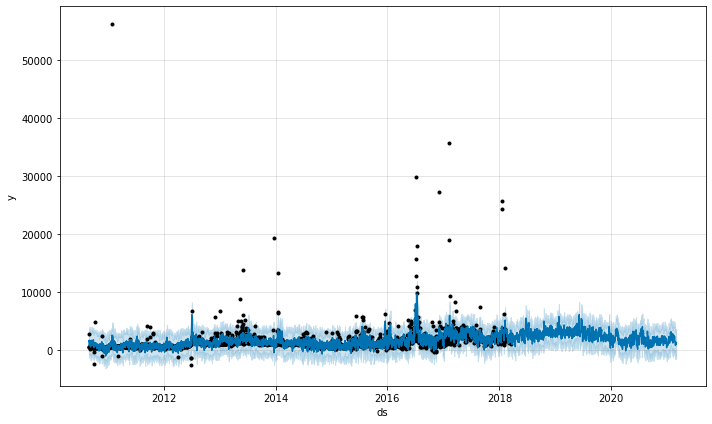

In [68]:
model.plot(predict)
plt.show()

In [69]:
# MAPE
mean_absolute_percentage_error( df_daily_test['y'][-df_cutoff:], predict['yhat'][df_cutoff:])

233.74494702819595

In [70]:
# RMSE
rmse_2 = sqrt(mean_squared_error( df_daily_test['y'][-df_cutoff:], predict['yhat'][df_cutoff:]))
print(rmse_2)

2709.6493421662344


In [71]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df1['ElecPrice']) 
print(f'ADF Statistic: {adf_result[0]}') 
print(f'p-value: {adf_result[1]}') 
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
    print(f'   {k}: {v}')

ADF Statistic: -31.952975699557843
p-value: 0.0
No. of lags used: 53
No. of observations used : 91962
Critical Values:
   1%: -3.430421110703783
   5%: -2.8615714297867108
   10%: -2.56678672898094


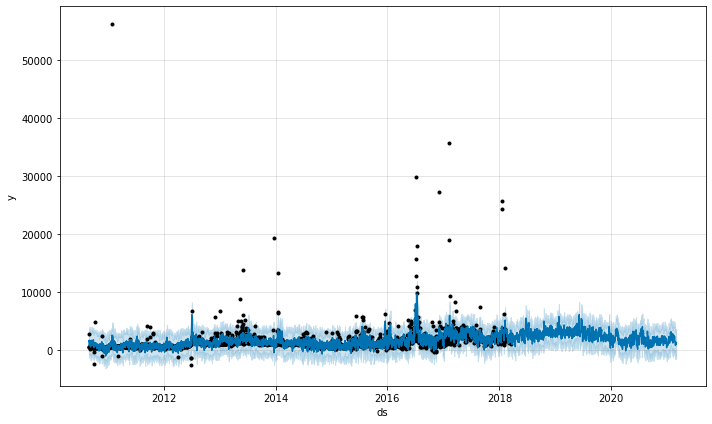

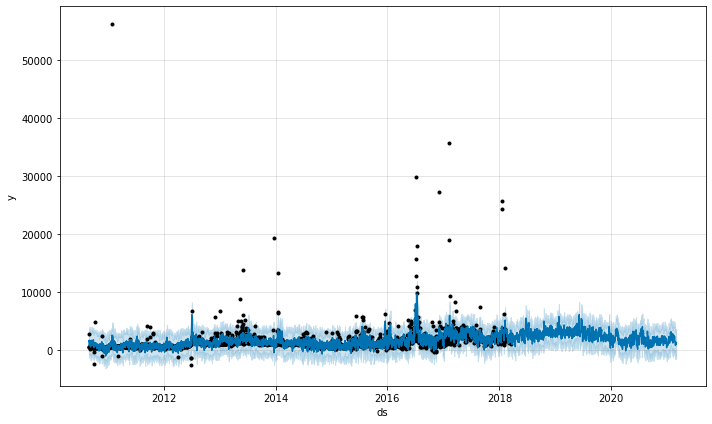

In [72]:
model.plot(predict)

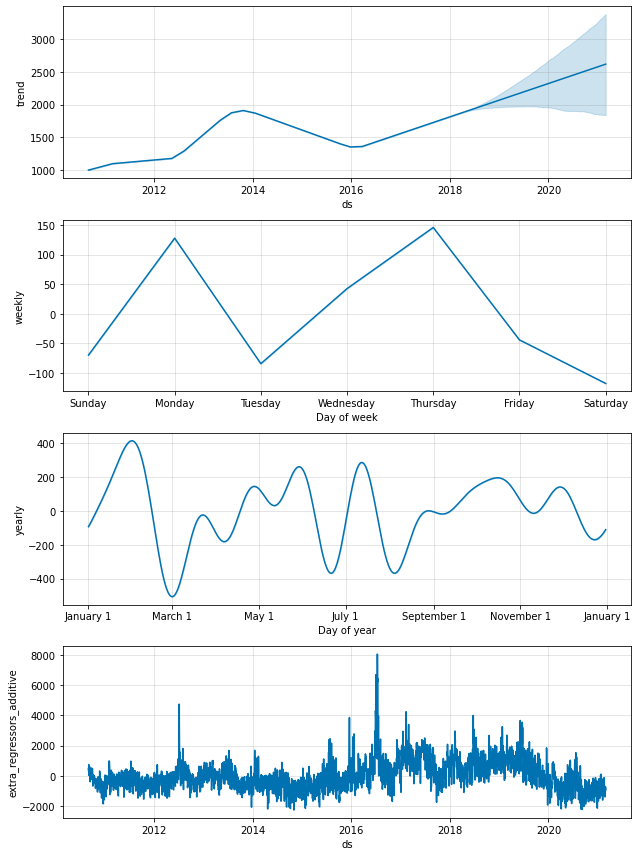

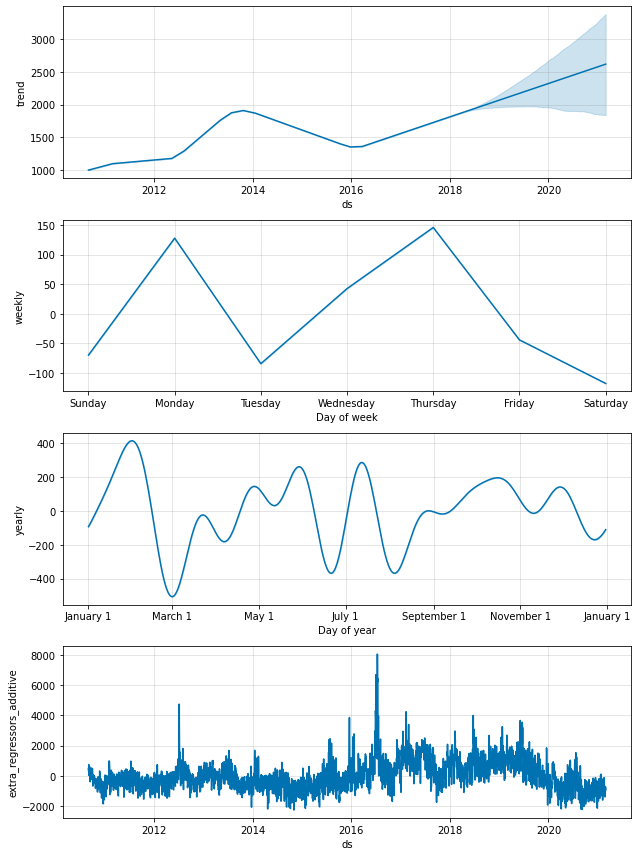

In [73]:
model.plot_components(predict)